In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
from astropy import units as u
from astropy.io import ascii
from astroquery.xmatch import XMatch
from astropy.table import Table, vstack
from astropy.coordinates import SkyCoord, ICRS, Galactic, Angle
from astropy.time import Time
from tqdm import tqdm
from scipy.stats import norm
import scipy.stats

In [2]:
pi = np.pi
sin = np.sin
cos = np.cos
log10 = np.log10
sqrt = np.sqrt

c=2.99792458*(10**8)
G=6.67428*(10**(-11))
s_mass=G*(1.98892*10**(30))/(c**3)

In [3]:
files = glob.glob('../IPTA_DR1/*/*.par')

In [4]:
def hist_weight(lst):
    return np.ones_like(lst)/len(lst)

def auto_bin(bin_size, min_edge, max_edge):
    #bin_size = 0.05; min_edge = -3.5; max_edge = -1
    N = (max_edge-min_edge)/bin_size; Nplus1 = N + 1
    bin_list = np.linspace(min_edge, max_edge, Nplus1)
    return bin_list

def ang_dist(alpha1, alpha2, delta1, delta2):
    """
    RA (alpha) and DEC (delta) are both in radians.
    returns angular distance in arcseconds.
    """
    alpha1 = alpha1*pi/180
    alpha2 = alpha2*pi/180
    delta1 = delta1*pi/180
    delta2 = delta2*pi/180

    arg = sin(delta1)*sin(delta2)+cos(delta1)*cos(delta2)*cos(alpha1-alpha2)
    theta = np.arccos(arg)*180/pi*3600
    est = np.sqrt(2*(1-arg))
    return theta

# plotting preamble

fig_width_pt = 245.27 #513.17           # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inches
golden_mean = (np.sqrt(5)-1.0)/2.0      # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height =fig_width*golden_mean       # height in inches
fig_size = [fig_width,fig_height]

params = {'backend': 'pdf',
        'axes.labelsize': 7,
        'lines.markersize': 2,
        'font.size': 7,
        'xtick.major.size':6,
        'xtick.minor.size':3,  
        'ytick.major.size':6,
        'ytick.minor.size':3, 
        'xtick.major.width':0.5,
        'ytick.major.width':0.5,
        'xtick.minor.width':0.5,
        'ytick.minor.width':0.5,
        'lines.markeredgewidth':1,
        'axes.linewidth':1.0,
        'legend.fontsize': 7,
        'xtick.labelsize': 7,
        'ytick.labelsize': 7,
        'savefig.dpi':200,
        'path.simplify':True,
        #'font.family': 'serif',
        'font.serif':'Times',
        'text.latex.preamble': [r'\usepackage{amsmath}'],
        'text.usetex':True,
        #'axes.color_cycle': ['b', 'lime', 'r', 'purple', 'g', 'c', 'm', 'orange', 'darkblue', \
        #                        'darkcyan', 'y','orangered','chartreuse','brown','deeppink','lightgreen', 'k'],
        #'font.serif':cm,
        'figure.figsize': fig_size}
plt.rcParams.update(params)

In [5]:
RAs = []
DECs = []
Names = []
pmra = []
pmra_err = []
pmdec = []
pmdec_err = []
pepoch = []
posepoch = []
dmepoch = []
dm = []
coords = []

In [6]:
for file in files:
    d = {}
    with open(file) as f:
        for line in f:
            key = line.split()[0]
            value = line.split()[1]
            d[key] = value
            if key in ['RAJ', 'DECJ', 'PMRA', 'PMDEC', 'PX']:
                try:
                    err = line.split()[3]
                    d[key+'_ERR'] = err
                except:
                    print("this file is missing uncertainties \
on {0}: {1}".format(key, file))
                    d[key+'_ERR'] = 0.0
    
    try:
        ra = Angle(d['RAJ'], u.hourangle).to(u.deg)
        dec = Angle(d['DECJ'], u.degree)
        coord = SkyCoord(ra=ra, dec=dec, frame='icrs',
                         pm_ra_cosdec = float(d['PMRA'])*u.mas/u.yr,
                         pm_dec=float(d['PMDEC'])*u.mas/u.yr,
                         obstime=Time(float(d['POSEPOCH']), format='mjd'),
                         distance=1. * u.kpc) # HACK
        coords.append(coord)
        RAs.append(ra.value)
        DECs.append(dec.value)
        Names.append(d['PSRJ'])
        pmra.append(coord.pm_ra_cosdec.value)
        pmra_err.append(float(d['PMRA_ERR']))
        pmdec.append(coord.pm_dec.value)
        pmdec_err.append(float(d['PMDEC_ERR']))
        pepoch.append(d['PEPOCH'])
        posepoch.append(d['POSEPOCH'])
        dmepoch.append(d['DMEPOCH'])
        dm.append(d['DM'])
        
    except KeyError:
        lon = float(d['ELONG'])*u.deg
        lat = float(d['ELAT'])*u.deg
        coord = SkyCoord(l=lon, b=lat, frame='galactic',
                             pm_l_cosb = float(d['PMELONG'])*u.mas/u.yr, 
                             pm_b=float(d['PMELAT'])*u.mas/u.yr,
                             obstime=Time(float(d['POSEPOCH']), format='mjd'),
                             distance=1. * u.kpc) # HACKITY HACK HACK
        icrscoord = coord.transform_to(ICRS)
        coords.append(icrscoord)
        print("this object has galactic coords: {0}".format(d['PSRJ']))
        RAs.append(icrscoord.ra.to(u.deg).value)
        DECs.append(icrscoord.dec.to(u.deg).value)
        Names.append(d['PSRJ'])
        pmra.append(icrscoord.pm_ra_cosdec.value)
        pmra_err.append(0.0) # TEMPORARY HACK
        pmdec.append(icrscoord.pm_dec.value)
        pmdec_err.append(0.0) # TEMPORARY HACK
        pepoch.append(d['PEPOCH'])
        posepoch.append(d['POSEPOCH'])
        dmepoch.append(d['DMEPOCH'])
        dm.append(d['DM']) 

this file is missing uncertainties on RAJ: ../IPTA_DR1/J0437-4715/J0437-4715.par
this file is missing uncertainties on DECJ: ../IPTA_DR1/J0437-4715/J0437-4715.par
this file is missing uncertainties on PMRA: ../IPTA_DR1/J0437-4715/J0437-4715.par
this file is missing uncertainties on PMDEC: ../IPTA_DR1/J0437-4715/J0437-4715.par
this file is missing uncertainties on PX: ../IPTA_DR1/J0437-4715/J0437-4715.par
this object has galactic coords: J1022+1001
this file is missing uncertainties on RAJ: ../IPTA_DR1/J1643-1224/J1643-1224.par
this file is missing uncertainties on DECJ: ../IPTA_DR1/J1643-1224/J1643-1224.par
this file is missing uncertainties on PMRA: ../IPTA_DR1/J1643-1224/J1643-1224.par
this file is missing uncertainties on PMDEC: ../IPTA_DR1/J1643-1224/J1643-1224.par
this file is missing uncertainties on PX: ../IPTA_DR1/J1643-1224/J1643-1224.par


In [7]:
#Names

### a bad case: J1910+1256

In [8]:
ind = np.where(np.array(Names) == 'J1910+1256')[0][0]

In [9]:
ipta_pmra_err = pmra_err[ind]
ipta_pmdec_err = pmdec_err[ind]
ipta_posepoch = posepoch[ind]

In [10]:
ipta_coord = coords[ind]
ipta_coord

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, kpc)
    (287.54042259, 12.9404131, 1.)
 (pm_ra_cosdec, pm_dec) in mas / yr
    (0.25061013, -6.93472136)>

In [11]:
gaia_time = Time(57023., format='mjd')
gaia_match_coord =  SkyCoord(ra=287.5407215 * u.degree, 
                             dec=12.94037301 * u.degree, frame='icrs',
                         pm_ra_cosdec = -0.672057539 *u.mas/u.yr,
                         pm_dec= -5.449112763 *u.mas/u.yr,
                         obstime=Time(2015.5, format='decimalyear'),
                         distance=1. * u.kpc) # HACK
gaia_ra_err = 0.576369178
gaia_dec_err = 0.623526292
gaia_match_coord

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, kpc)
    (287.5407215, 12.94037301, 1.)
 (pm_ra_cosdec, pm_dec) in mas / yr
    (-0.67205754, -5.44911276)>

In [13]:
# My angular separation calc for 1910

mySep = ang_dist(287.54042259, 287.5407215, 12.9404131, 12.94037301)


In [14]:
gaia_ipta_sep = ipta_coord.apply_space_motion(new_obstime=gaia_time).separation(gaia_match_coord).arcsec
gaia_ipta_sep

1.0526847597792082

In [15]:
N = 6000
seps = []
ipta_ras = []
ipta_decs = []
gaia_ras = []
gaia_decs = []
for n in tqdm(range(N)):
    c1 = SkyCoord(ra=ipta_coord.ra,
                 dec=ipta_coord.dec, frame='icrs',
                 pm_ra_cosdec=np.random.normal(ipta_coord.pm_ra_cosdec.value, 
                                               ipta_pmra_err) * u.mas/u.yr,
                 pm_dec=np.random.normal(ipta_coord.pm_dec.value, 
                                               ipta_pmdec_err) * u.mas/u.yr,
                 obstime=ipta_coord.obstime,
                 distance=ipta_coord.distance)
    c2 = SkyCoord(ra=np.random.normal(gaia_match_coord.ra.arcsec, gaia_ra_err) * u.arcsec,
                 dec=np.random.normal(gaia_match_coord.dec.arcsec, gaia_dec_err) * u.arcsec, 
                 frame='icrs',
                 pm_ra_cosdec=gaia_match_coord.pm_ra_cosdec, 
                 pm_dec=gaia_match_coord.pm_dec, 
                 obstime=gaia_match_coord.obstime,
                 distance=gaia_match_coord.distance)
    ipta_ras.append(c1.apply_space_motion(new_obstime=gaia_time).ra.degree)
    ipta_decs.append(c1.apply_space_motion(new_obstime=gaia_time).dec.degree)
    gaia_ras.append(c2.ra.degree)
    gaia_decs.append(c2.dec.degree)
    sep = c1.apply_space_motion(new_obstime=gaia_time).separation(c2).arcsec
    seps.append(sep)

100%|██████████| 6000/6000 [12:28<00:00,  8.02it/s]


In [16]:
gaia_ras = np.array(gaia_ras)-287.54
ipta_ras = np.array(ipta_ras)-287.54


In [17]:
bin_list = auto_bin(np.std(gaia_ras)/5,np.min(gaia_ras)-np.std(gaia_ras),np.max(gaia_ras)+np.std(gaia_ras))
weights = hist_weight(gaia_ras)

/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  import sys


In [18]:
np.std(gaia_ras)

0.0001606497118632693

In [19]:
(mu, sigma) = norm.fit(gaia_ras)
diff = (mu-np.median(ipta_ras))/sigma

In [20]:
(mu, sigma)

(0.0007200869180494749, 0.0001606497118632693)

In [21]:
diff

1.8493704282592887

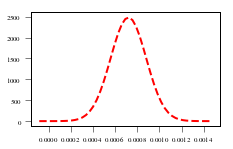

In [22]:
# add a 'best fit' line
y = norm.fit(gaia_ras)

y = scipy.stats.norm.pdf(bin_list, mu, sigma)

l = plt.plot(bin_list, y, 'r--', linewidth=2)

In [23]:
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

In [24]:
normed = []
for xx in range(len(bin_list)):
    normed.append(gaussian(bin_list[xx], mu, sigma))

/anaconda2/envs/py3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


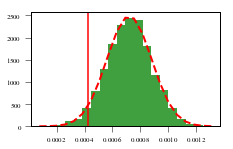

In [25]:
datos = gaia_ras
(mu, sigma) = norm.fit(datos)

# the histogram of the data
n, bins, patches = plt.hist(datos, 20, normed=.12, facecolor='green', alpha=0.75)

# add a 'best fit' line
y = scipy.stats.norm.pdf(bins, mu, sigma)

l = plt.plot(bins, y, 'r--', linewidth=2)
plt.axvline(np.median(ipta_ras), color='red', label = "IPTA")



In [26]:
ipta_ras = np.array(ipta_ras)

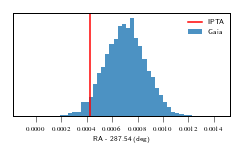

In [27]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.hist(np.array(gaia_ras), bin_list, weights=weights, alpha = 0.8, align='left', color = 'C0', label = "Gaia")
plt.axvline(np.median(ipta_ras), color='red', label = "IPTA")
#y = mlab.normpdf(bin_list, mu, sigma)
#plt.plot(bin_list, normed, 'r--', linewidth=2, label=r"Gaussian Fit")
plt.xlabel("RA - 287.54 (deg)")
plt.yticks([])
#plt.ylabel("Probability")
plt.legend(frameon=False)
plt.tight_layout()
plt.savefig("J1910_RA_IPTA-GAIA-final-24Nov18.pdf")

In [28]:
2.8754e2

287.54

In [29]:
sigmaRA

NameError: name 'sigmaRA' is not defined

In [30]:
bin_list = auto_bin(np.std(gaia_decs)/4,np.min(gaia_decs)-np.std(gaia_decs),np.max(gaia_decs)+np.std(gaia_decs))
weights = hist_weight(gaia_decs)

/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  import sys


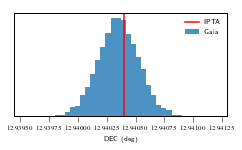

In [32]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.hist(gaia_decs, bin_list, weights=weights, alpha = 0.8, align='left', color = 'C0', label = "Gaia")
plt.axvline(np.median(ipta_decs), color='red', label = "IPTA") #0.2 sigma
plt.xlabel("DEC (deg)")
plt.yticks([])
#plt.ylabel("Probability")
plt.legend(frameon=False)
plt.tight_layout()
#plt.savefig("J1910_DEC_IPTA-GAIA-final-25Nov.pdf")

In [27]:
(mu, sigma) = norm.fit(gaia_decs)
diff = (mu-np.median(ipta_decs))/sigma

In [28]:
diff

-0.05788084753940657

In [29]:
bin_list = auto_bin(np.std(seps)/3,np.min(seps)-np.std(seps),np.max(seps)+np.std(seps))
weights = hist_weight(seps)

/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  import sys


In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.hist(np.array(seps), bin_list, weights=weights, alpha = 0.8, align='left', color = 'C0', label = "Gaia")
plt.axvline(np.median(gaia_ipta_sep), color='red', label = "IPTA")
plt.xlabel(r"J1910+1256, Angular Separation $\theta$ (arcsecs)") #0.35 sigma
plt.ylabel("Probability")
plt.legend(frameon=False)
plt.tight_layout()
plt.savefig("1910_thetas.pdf")

In [ ]:
(mu, sigma) = norm.fit(seps)
diff = (mu-np.median(gaia_ipta_sep))/sigma

In [ ]:
diff

In [ ]:
bin_listIPTA = auto_bin(np.std(gaia_ipta_sep)/3,np.min(gaia_ipta_sep)
                        -np.std(gaia_ipta_sep),np.max(gaia_ipta_sep)+np.std(gaia_ipta_sep))
weightsIPTA = hist_weight(gaia_ipta_sep)

## a not-so-bad disagreement case: J1012+5307

In [30]:
ind = np.where(np.array(Names) == 'J1012+5307')[0][0]

In [31]:
ipta_pmra_err = pmra_err[ind]
ipta_pmdec_err = pmdec_err[ind]
ipta_posepoch = posepoch[ind]

In [32]:
ipta_coord = coords[ind]
ipta_coord

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, kpc)
    (153.13932304, 53.1173056, 1.)
 (pm_ra_cosdec, pm_dec) in mas / yr
    (2.62371226, -25.45880892)>

In [33]:
gaia_time = Time(57023., format='mjd')
gaia_match_coord =  SkyCoord(ra=153.1393303 * u.degree, 
                             dec=53.11726303 * u.degree, frame='icrs',
                         pm_ra_cosdec = 2.976959985 *u.mas/u.yr,
                         pm_dec= -26.94384758 *u.mas/u.yr,
                         obstime= gaia_time,
                         distance=1. * u.kpc) # HACK
gaia_ra_err = 0.241174616
gaia_dec_err = 0.302546482
gaia_match_coord

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, kpc)
    (153.1393303, 53.11726303, 1.)
 (pm_ra_cosdec, pm_dec) in mas / yr
    (2.97695999, -26.94384758)>

In [34]:
gaia_ipta_sep = ipta_coord.apply_space_motion(new_obstime=gaia_time).separation(gaia_match_coord).arcsec
gaia_ipta_sep

0.012298049411488533

In [35]:
N = 5000
seps = []
ipta_ras = []
ipta_decs = []
gaia_ras = []
gaia_decs = []
for n in tqdm(range(N)):
    c1 = SkyCoord(ra=ipta_coord.ra,
                 dec=ipta_coord.dec, frame='icrs',
                 pm_ra_cosdec=np.random.normal(ipta_coord.pm_ra_cosdec.value, 
                                               ipta_pmra_err) * u.mas/u.yr,
                 pm_dec=np.random.normal(ipta_coord.pm_dec.value, 
                                               ipta_pmdec_err) * u.mas/u.yr,
                 obstime=ipta_coord.obstime,
                 distance=ipta_coord.distance)
    c2 = SkyCoord(ra=np.random.normal(gaia_match_coord.ra.arcsec, gaia_ra_err) * u.arcsec,
                 dec=np.random.normal(gaia_match_coord.dec.arcsec, gaia_dec_err) * u.arcsec, 
                 frame='icrs',
                 pm_ra_cosdec=gaia_match_coord.pm_ra_cosdec, 
                 pm_dec=gaia_match_coord.pm_dec, 
                 obstime=gaia_match_coord.obstime,
                 distance=gaia_match_coord.distance)
    ipta_ras.append(c1.apply_space_motion(new_obstime=gaia_time).ra.degree)
    ipta_decs.append(c1.apply_space_motion(new_obstime=gaia_time).dec.degree)
    gaia_ras.append(c2.ra.degree)
    gaia_decs.append(c2.dec.degree)
    sep = c1.apply_space_motion(new_obstime=gaia_time).separation(c2).arcsec
    seps.append(sep)

100%|██████████| 5000/5000 [08:37<00:00,  9.66it/s]


In [36]:
bin_list = auto_bin(np.std(seps)/4,np.min(seps)-np.std(seps),np.max(seps)+np.std(seps))
weights = hist_weight(seps)

/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  import sys


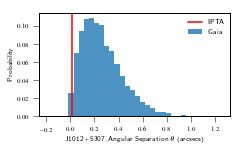

In [37]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.hist(np.array(seps), bin_list, weights=weights, alpha = 0.8, align='left', color = 'C0', label = "Gaia")
plt.axvline(np.median(gaia_ipta_sep), color='red', label = "IPTA")
plt.xlabel(r"J1012+5307, Angular Separation $\theta$ (arcsecs)") #1.6 sigma
plt.ylabel("Probability")
plt.legend(frameon=False)
plt.tight_layout()
plt.savefig("1012_thetas_25Nov.pdf")

In [38]:
(mu, sigma) = norm.fit(seps)
diff = (mu-np.median(gaia_ipta_sep))/sigma

In [39]:
diff

1.6133533722627242

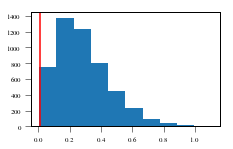

In [40]:
plt.hist(seps)
plt.axvline(gaia_ipta_sep, c='red')

In [41]:
gaia_ras = np.array(gaia_ras) -1.53139e2 #for better plotting

In [42]:
bin_list = auto_bin(np.std(gaia_ras)/4,np.min(gaia_ras)-np.std(gaia_ras)/2,np.max(gaia_ras)+np.std(gaia_ras)/2)
weights = hist_weight(gaia_ras)

/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  import sys


In [43]:
(mu, sigma) = norm.fit(gaia_ras)
diff = (mu-np.median(ipta_ras))/sigma

In [44]:
mu

0.0003298744804275884

In [45]:
diff

-2334041.005485071

In [46]:
ipta_ras = np.array(ipta_ras) -153.139

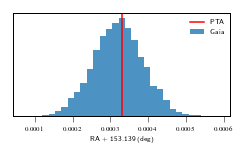

In [48]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.hist(np.array(gaia_ras), bin_list, weights=weights, alpha = 0.8, align='left', color = 'C0', label = "Gaia")
plt.axvline(np.median(ipta_ras), color='red', label = "PTA")
#y = mlab.normpdf(bin_list, mu, sigma)
#plt.plot(bin_list, normed, 'r--', linewidth=2, label=r"Gaussian Fit") # this is 0.04 sigma from mean
plt.xlabel("RA + 153.139 (deg)")
#plt.ylabel("Probability")
plt.yticks([])
plt.legend(frameon=False)
plt.tight_layout()
#plt.savefig("J1012_RA_IPTA-GAIA-25Nov.pdf")

In [49]:
gaia_decs=np.array(gaia_decs) -53.117

In [50]:
gaia_decs

array([0.00021917, 0.00030943, 0.00051012, ..., 0.00023939, 0.00022154,
       0.00045265])

In [51]:
bin_list = auto_bin(np.std(gaia_decs)/4,np.min(gaia_decs)-np.std(gaia_decs)/2,np.max(gaia_decs)+np.std(gaia_decs)/2)
weights = hist_weight(gaia_decs)

/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  import sys


In [52]:
(mu, sigma) = norm.fit(gaia_decs)
diff = (mu-np.median(ipta_decs))/sigma

In [53]:
ipta_decs = np.array(ipta_decs) - 53.117

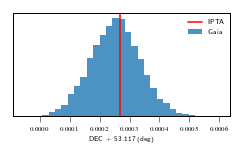

In [54]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.hist(np.array(gaia_decs), bin_list, weights=weights, alpha = 0.8, align='left', color = 'C0', label = "Gaia")
plt.axvline(np.median(ipta_decs), color='red', label = "IPTA")
#y = mlab.normpdf(bin_list, mu, sigma)
#plt.plot(bin_list, normed, 'r--', linewidth=2, label=r"Gaussian Fit") # this is 0.04 sigma from mean
plt.xlabel("DEC + 53.117 (deg)")
#plt.ylabel("Probability")
plt.yticks([])
plt.legend(frameon=False)
plt.tight_layout()
#plt.savefig("J1012_DEC_IPTA-GAIA-25Nov.pdf")

In [ ]:
diff 


## Best pulasr, J0437-4715


In [55]:
ind = np.where(np.array(Names) == 'J0437-4715')[0][0]

In [56]:
ipta_pmra_err = pmra_err[ind]
ipta_pmdec_err = pmdec_err[ind]
ipta_posepoch = posepoch[ind]

In [57]:
ipta_pmra_err = 0.052 #Deller et al. 2008, Table 1
ipta_pmdec_err = 0.086 #Deller et al. 2008
ipta_posepoch = posepoch[ind]


In [58]:
ipta_posepoch

'54500'

In [59]:
arcSec2Deg = 0.000277778

In [60]:
ipta_coord = coords[ind]
ipta_coord

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, kpc)
    (69.31623406, -47.25253075, 1.)
 (pm_ra_cosdec, pm_dec) in mas / yr
    (121.43993282, -71.47620158)>

In [61]:
gaia_time = Time(57023., format='mjd') # CHECK THAT THIS IS REALLY 2015.5 IN MJD
gaia_match_coord =  SkyCoord(ra=69.31660276 * u.degree, 
                             dec=-47.25267778 * u.degree, frame='icrs',
                         pm_ra_cosdec = 122.8637296 *u.mas/u.yr,
                         pm_dec= -71.16597382 *u.mas/u.yr,
                         obstime=Time(2015.5, format='decimalyear'),
                         distance=1. * u.kpc) # HACK
gaia_ra_err = 0.582326756
gaia_dec_err = 0.738504992
gaia_match_coord

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, kpc)
    (69.31660276, -47.25267778, 1.)
 (pm_ra_cosdec, pm_dec) in mas / yr
    (122.8637296, -71.16597382)>

In [62]:
gaia_ipta_sep = ipta_coord.apply_space_motion(new_obstime=gaia_time).separation(gaia_match_coord).arcsec
gaia_ipta_sep

0.07154597070179823

In [63]:
0.071544965

0.071544965

In [64]:
N = 6000
seps = []
ipta_ras = []
ipta_decs = []
gaia_ras = []
gaia_decs = []
for n in tqdm(range(N)):
    c1 = SkyCoord(ra=ipta_coord.ra,
                 dec=ipta_coord.dec, frame='icrs',
                 pm_ra_cosdec=np.random.normal(ipta_coord.pm_ra_cosdec.value, 
                                               ipta_pmra_err) * u.mas/u.yr,
                 pm_dec=np.random.normal(ipta_coord.pm_dec.value, 
                                               ipta_pmdec_err) * u.mas/u.yr,
                 obstime=ipta_coord.obstime,
                 distance=ipta_coord.distance)
    c2 = SkyCoord(ra=np.random.normal(gaia_match_coord.ra.arcsec, gaia_ra_err) * u.arcsec,
                 dec=np.random.normal(gaia_match_coord.dec.arcsec, gaia_dec_err) * u.arcsec, 
                 frame='icrs',
                 pm_ra_cosdec=gaia_match_coord.pm_ra_cosdec, 
                 pm_dec=gaia_match_coord.pm_dec, 
                 obstime=gaia_match_coord.obstime,
                 distance=gaia_match_coord.distance)
    ipta_ras.append(c1.apply_space_motion(new_obstime=gaia_time).ra.degree)
    #print(ipta_ras)
    ipta_decs.append(c1.apply_space_motion(new_obstime=gaia_time).dec.degree)
    gaia_ras.append(c2.ra.degree)
    gaia_decs.append(c2.dec.degree)
    sep = c1.apply_space_motion(new_obstime=gaia_time).separation(c2).arcsec
    seps.append(sep)

100%|██████████| 6000/6000 [13:13<00:00,  7.56it/s]


In [ ]:
bin_list = auto_bin(.05,-0.01,1)
weights = hist_weight(seps)

ValueError: weights should have the same shape as x

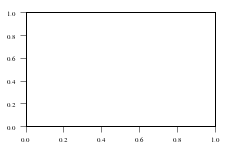

In [65]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.hist(seps, bin_list, weights=weights, alpha = 0.8, align='left', color = 'C0', label = "Gaia")
plt.axvline(gaia_ipta_sep, color='red', label = "IPTA")
plt.xlabel(r"J0437-4715, Angular Separation $\theta$ (arcsecs)")
plt.yticks([])
#plt.ylabel("Probability")
plt.legend(frameon=False)
plt.tight_layout()
#plt.savefig("J0437_Theta_IPTA-GAIA-25Nov.pdf")



In [66]:
ipta_ras = np.array(ipta_ras) - 69.31
gaia_ras = np.array(gaia_ras) - 69.31

In [67]:
bin_list = auto_bin(np.std(gaia_ras)/5,np.min(gaia_ras)-np.std(gaia_ras)/2,np.max(gaia_ras)+np.std(gaia_ras)/2)
weights = hist_weight(gaia_ras)

/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  import sys


In [68]:
max(gaia_ras)

0.0072627308293817805

In [69]:
max(ipta_ras)

0.006577914622397429

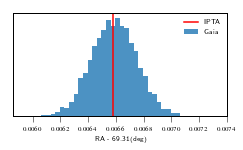

In [71]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.hist(gaia_ras, bin_list, weights=weights, alpha = 0.8, align='left', color = 'C0', label = "Gaia")
plt.axvline(np.median(ipta_ras), color='red', label = "IPTA") #0.13 sigma
plt.xlabel("RA - 69.31(deg)")
#plt.ylabel("Probability")
plt.yticks([])
plt.legend(frameon=False)
plt.tight_layout()
#plt.savefig("J0437_RA_IPTA-GAIA-25Nov.pdf")

In [72]:
(mu, sigma) = norm.fit(gaia_ras)
diff = (mu-np.median(ipta_ras))/sigma

In [73]:
diff

0.16473636724502366

In [74]:
bin_list = auto_bin(np.std(gaia_decs)/4,np.min(gaia_decs)-np.std(gaia_decs)/2,np.max(gaia_decs)+np.std(gaia_decs)/2)
weights = hist_weight(gaia_decs)

/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  import sys


In [81]:
ipta_decs = np.array(ipta_decs) - 47.25
gaia_decs = np.array(gaia_decs) - 47.25

In [82]:
ipta_decs

array([-47.25266788, -47.252668  , -47.25266823, ..., -47.25266788,
       -47.25266785, -47.25266774])

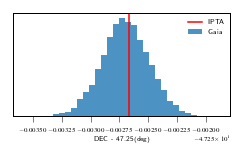

In [84]:
# DEC plot for J0437
plt.hist(gaia_decs, bin_list, weights=weights, alpha = 0.8, align='left', color = 'C0', label = "Gaia")
#plt.hist(ipta_decs, bin_list2, weights=weights2, alpha = 0.8, align='left', color = 'C1', label = "IPTA")
plt.axvline(np.median(ipta_decs), color='red', label = "IPTA")
##ax.set_xlim([np.min(ipta_decs),np.max(ipta_decs)])
plt.xlabel("DEC - 47.25(deg)")
#plt.ylabel("Probability")
plt.yticks([])
plt.legend(frameon=False)
plt.tight_layout()
#plt.savefig("J0437_DEC_IPTA-GAIA-25Nov.pdf")

In [ ]:
(mu, sigma) = norm.fit(gaia_decs)
diff = (mu-np.median(ipta_decs))/sigma

In [ ]:
diff

In [ ]:
ipta_decs + 47.25

## Pulsar J1024-0719

In [85]:
ind = np.where(np.array(Names) == 'J1024-0719')[0][0]

ipta_pmra_err = pmra_err[ind]
ipta_pmdec_err = pmdec_err[ind]
ipta_posepoch = posepoch[ind]

ipta_pmra_err = pmra_err[ind]
ipta_pmdec_err = pmdec_err[ind]
ipta_posepoch = posepoch[ind]


ipta_coord = coords[ind]
ipta_coord

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, kpc)
    (156.16114741, -7.32206499, 1.)
 (pm_ra_cosdec, pm_dec) in mas / yr
    (-35.3049269, -48.24394017)>

In [86]:
gaia_time = Time(57023., format='mjd')
gaia_match_coord =  SkyCoord(ra=156.1610927 * u.degree, 
                             dec=-7.322165289 * u.degree, frame='icrs',
                         pm_ra_cosdec = -35.51929892*u.mas/u.yr,
                         pm_dec= -47.93231066 *u.mas/u.yr,
                         obstime=Time(2015.5, format='decimalyear'),
                         distance=1. * u.kpc) # HACK
gaia_ra_err = 0.42985265
gaia_dec_err = 0.392656637
gaia_match_coord

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, kpc)
    (156.1610927, -7.32216529, 1.)
 (pm_ra_cosdec, pm_dec) in mas / yr
    (-35.51929892, -47.93231066)>

In [87]:
gaia_ipta_sep = ipta_coord.apply_space_motion(new_obstime=gaia_time).separation(gaia_match_coord).arcsec
gaia_ipta_sep

0.09388321101894358

In [88]:
N = 6000
seps = []
ipta_ras = []
ipta_decs = []
gaia_ras = []
gaia_decs = []
for n in tqdm(range(N)):
    c1 = SkyCoord(ra=ipta_coord.ra,
                 dec=ipta_coord.dec, frame='icrs',
                 pm_ra_cosdec=np.random.normal(ipta_coord.pm_ra_cosdec.value, 
                                               ipta_pmra_err) * u.mas/u.yr,
                 pm_dec=np.random.normal(ipta_coord.pm_dec.value, 
                                               ipta_pmdec_err) * u.mas/u.yr,
                 obstime=ipta_coord.obstime,
                 distance=ipta_coord.distance)
    c2 = SkyCoord(ra=np.random.normal(gaia_match_coord.ra.arcsec, gaia_ra_err) * u.arcsec,
                 dec=np.random.normal(gaia_match_coord.dec.arcsec, gaia_dec_err) * u.arcsec, 
                 frame='icrs',
                 pm_ra_cosdec=gaia_match_coord.pm_ra_cosdec, 
                 pm_dec=gaia_match_coord.pm_dec, 
                 obstime=gaia_match_coord.obstime,
                 distance=gaia_match_coord.distance)
    ipta_ras.append(c1.apply_space_motion(new_obstime=gaia_time).ra.degree)
    ipta_decs.append(c1.apply_space_motion(new_obstime=gaia_time).dec.degree)
    gaia_ras.append(c2.ra.degree)
    gaia_decs.append(c2.dec.degree)
    sep = c1.apply_space_motion(new_obstime=gaia_time).separation(c2).arcsec
    seps.append(sep)

100%|██████████| 6000/6000 [12:14<00:00,  8.17it/s]


In [89]:
bin_list = auto_bin(.08,0.0,1.8)
weights = hist_weight(seps)

/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  import sys


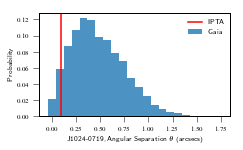

In [90]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.hist(seps, bin_list, weights=weights, alpha = 0.8, align='left', color = 'C0', label = "Gaia")
plt.axvline(gaia_ipta_sep, color='red', label = "IPTA")
plt.xlabel(r"J1024-0719, Angular Separation $\theta$ (arcsecs)")
plt.ylabel("Probability")
plt.legend(frameon=False)
plt.tight_layout()
plt.savefig("J1024_Theta_IPTA-GAIA.pdf")

In [110]:
gaia_ras = np.array(gaia_ras) + 1.5616e2

In [111]:
ipta_ras = np.array(ipta_ras) + 1.5616e2

In [112]:
bin_list = auto_bin(np.std(gaia_ras)/4,np.min(gaia_ras)-np.std(gaia_ras)/2,np.max(gaia_ras)+np.std(gaia_ras)/2)
weights = hist_weight(gaia_ras)

/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  import sys


In [113]:
(mu, sigma) = norm.fit(gaia_ras)
diff = (mu-np.median(ipta_ras))/sigma

In [114]:
diff

-0.016031147001955497

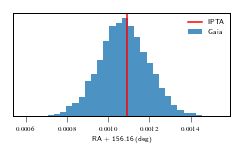

In [115]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.hist(gaia_ras, bin_list, weights=weights, alpha = 0.8, align='left', color = 'C0', label = "Gaia")
plt.axvline(np.median(ipta_ras), color='red', label = "IPTA") #0.06 sigma, great fit!
plt.xlabel("RA + 156.16 (deg)")
plt.yticks([])
plt.legend(frameon=False)
plt.tight_layout()
#plt.savefig("J1024_RA_IPTA-GAIA.pdf")

In [117]:
bin_list = auto_bin(np.std(gaia_decs)/4,np.min(gaia_decs)-np.std(gaia_decs)/2,np.max(gaia_decs)+np.std(gaia_decs)/2)
weights = hist_weight(gaia_decs)


/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  import sys


In [118]:
(mu, sigma) = norm.fit(gaia_decs)
diff = (mu-np.median(ipta_decs))/sigma



In [119]:
diff

-0.22442351126693835

In [120]:
diff

-0.22442351126693835

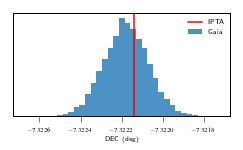

In [123]:
# DEC plot for J1024
plt.hist(gaia_decs, bin_list, weights=weights, alpha = 0.8, align='left', color = 'C0', label = "Gaia")
plt.axvline(np.median(ipta_decs), color='red', label = "IPTA") #0.2 sigma away
#ax.set_xlim([np.min(ipta_decs),np.max(ipta_decs)])
plt.xlabel("DEC (deg)")
plt.yticks([])

plt.legend(frameon=False)
plt.tight_layout()
#plt.savefig("J1024_DEC_IPTA-GAIA-25Nov.pdf")

## not so great pulsar J1732-5049

In [52]:
ind = np.where(np.array(Names) == 'J1732-5049')[0][0]

ipta_pmra_err = pmra_err[ind]
ipta_pmdec_err = pmdec_err[ind]
ipta_posepoch = posepoch[ind]

ipta_pmra_err = pmra_err[ind]
ipta_pmdec_err = pmdec_err[ind]
ipta_posepoch = posepoch[ind]


ipta_coord = coords[ind]
ipta_coord

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, kpc)
    (263.19902801, -50.81671992, 1.)
 (pm_ra_cosdec, pm_dec) in mas / yr
    (-0.4321012, -9.90996085)>

In [53]:
gaia_time = Time(57023., format='mjd')
gaia_match_coord =  SkyCoord(ra=263.200006 * u.degree, 
                             dec=-50.8166163 * u.degree, frame='icrs',
                         pm_ra_cosdec = -0.031849016*u.mas/u.yr,
                         pm_dec= -10.483062*u.mas/u.yr,
                         obstime=Time(2015.5, format='decimalyear'),
                         distance=1. * u.kpc) # HACK
gaia_ra_err = 2.168898313
gaia_dec_err = 2.010098257
gaia_match_coord

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, kpc)
    (263.200006, -50.8166163, 1.)
 (pm_ra_cosdec, pm_dec) in mas / yr
    (-0.03184902, -10.483062)>

In [54]:
gaia_ipta_sep = ipta_coord.apply_space_motion(new_obstime=gaia_time).separation(gaia_match_coord).arcsec
gaia_ipta_sep

2.270753721341421

In [55]:
N = 6000
seps = []
ipta_ras = []
ipta_decs = []
gaia_ras = []
gaia_decs = []
for n in tqdm(range(N)):
    c1 = SkyCoord(ra=ipta_coord.ra,
                 dec=ipta_coord.dec, frame='icrs',
                 pm_ra_cosdec=np.random.normal(ipta_coord.pm_ra_cosdec.value, 
                                               ipta_pmra_err) * u.mas/u.yr,
                 pm_dec=np.random.normal(ipta_coord.pm_dec.value, 
                                               ipta_pmdec_err) * u.mas/u.yr,
                 obstime=ipta_coord.obstime,
                 distance=ipta_coord.distance)
    c2 = SkyCoord(ra=np.random.normal(gaia_match_coord.ra.arcsec, gaia_ra_err) * u.arcsec,
                 dec=np.random.normal(gaia_match_coord.dec.arcsec, gaia_dec_err) * u.arcsec, 
                 frame='icrs',
                 pm_ra_cosdec=gaia_match_coord.pm_ra_cosdec, 
                 pm_dec=gaia_match_coord.pm_dec, 
                 obstime=gaia_match_coord.obstime,
                 distance=gaia_match_coord.distance)
    ipta_ras.append(c1.apply_space_motion(new_obstime=gaia_time).ra.degree)
    ipta_decs.append(c1.apply_space_motion(new_obstime=gaia_time).dec.degree)
    gaia_ras.append(c2.ra.degree)
    gaia_decs.append(c2.dec.degree)
    sep = c1.apply_space_motion(new_obstime=gaia_time).separation(c2).arcsec
    seps.append(sep)

100%|██████████| 6000/6000 [12:39<00:00,  7.90it/s]


In [56]:
bin_list = auto_bin(.5,0.0,8.0)
weights = hist_weight(seps)

/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  import sys


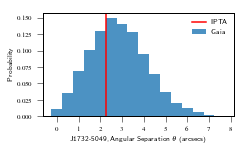

In [57]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.hist(seps, bin_list, weights=weights, alpha = 0.8, align='left', color = 'C0', label = "Gaia")
plt.axvline(gaia_ipta_sep, color='red', label = "IPTA")
plt.xlabel(r"J1732-5049, Angular Separation $\theta$ (arcsecs)")
plt.ylabel("Probability")
plt.legend(frameon=False)
plt.tight_layout()
#plt.savefig("J1732_Theta_IPTA-GAIA.pdf")

In [58]:
ipta_ras = np.array(ipta_ras)-263.2

In [59]:
gaia_ras = np.array(gaia_ras)-263.2

In [60]:
bin_list = auto_bin(np.std(gaia_ras)/4,np.min(gaia_ras)-np.std(gaia_ras)/2,np.max(gaia_ras)+np.std(gaia_ras)/2)
weights = hist_weight(gaia_ras)

/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  import sys


In [61]:
2.632e2

263.2

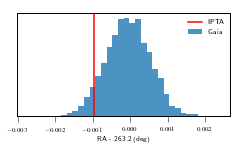

In [62]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.hist(gaia_ras, bin_list, weights=weights, alpha = 0.8, align='left', color = 'C0', label = "Gaia")
plt.axvline(np.median(ipta_ras), color='red', label = "IPTA") #1.57 sigma
plt.xlabel("RA - 263.2 (deg)")
plt.yticks([])
plt.legend(frameon=False)
plt.tight_layout()
plt.savefig("J1732_RA_IPTA-GAIA-25Nov.pdf")



In [66]:
(mu, sigma) = norm.fit(gaia_ras)
diff = (mu-np.median(ipta_ras))/sigma

In [67]:
mu

1.6122090962956767e-05

In [68]:
sigma

0.000598813137146556

In [69]:
diff

1.6523055628361352

In [84]:
bin_list = auto_bin(np.std(gaia_decs)/4,np.min(gaia_decs)-np.std(gaia_decs)/2,np.max(gaia_decs)+np.std(gaia_decs)/2)
weights = hist_weight(gaia_decs)



/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  import sys


In [79]:
gaia_decs = np.array(gaia_decs) - 50.81

In [80]:
ipta_decs = np.array(ipta_decs) - 50.81

In [83]:
gaia_decs

array([-0.00651988, -0.0069777 , -0.00657283, ..., -0.00721477,
       -0.00645463, -0.00696337])

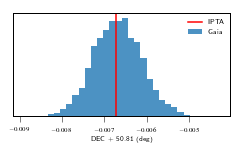

In [87]:
# DEC plot for J1024
plt.hist(gaia_decs, bin_list, weights=weights, alpha = 0.8, align='left', color = 'C0', label = "Gaia")
plt.axvline(np.median(ipta_decs), color='red', label = "IPTA") #0.26 sigma away
#ax.set_xlim([np.min(ipta_decs),np.max(ipta_decs)])

plt.xlabel("DEC + 50.81 (deg)")
plt.yticks([])
plt.legend(frameon=False)
plt.tight_layout()
#plt.savefig("J1732_DEC_IPTA-GAIA-25Nov.pdf")

In [26]:
(mu, sigma) = norm.fit(gaia_decs)
diff = (mu-np.median(ipta_decs))/sigma

In [27]:
diff

0.19751778442651127

## Pulsar J1955+2908

In [33]:
ind = np.where(np.array(Names) == 'J1955+2908')[0][0]

ipta_pmra_err = pmra_err[ind]
ipta_pmdec_err = pmdec_err[ind]
ipta_posepoch = posepoch[ind]

ipta_pmra_err = pmra_err[ind]
ipta_pmdec_err = pmdec_err[ind]
ipta_posepoch = posepoch[ind]


ipta_coord = coords[ind]
ipta_coord

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, kpc)
    (298.86614892, 29.14540536, 1.)
 (pm_ra_cosdec, pm_dec) in mas / yr
    (-0.81162453, -4.06546809)>

In [34]:
gaia_time = Time(57023., format='mjd')
gaia_match_coord =  SkyCoord(ra=298.8661015 * u.degree, 
                             dec=29.14538275 * u.degree, frame='icrs',
                         pm_ra_cosdec = -3.092116051*u.mas/u.yr,
                         pm_dec= -7.962991888*u.mas/u.yr,
                         obstime=Time(2015.5, format='decimalyear'),
                         distance=1. * u.kpc) # HACK
gaia_ra_err = 0.125519342
gaia_dec_err = 0.165511548
gaia_match_coord

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, kpc)
    (298.8661015, 29.14538275, 1.)
 (pm_ra_cosdec, pm_dec) in mas / yr
    (-3.09211605, -7.96299189)>

In [35]:
gaia_ipta_sep = ipta_coord.apply_space_motion(new_obstime=gaia_time).separation(gaia_match_coord).arcsec
gaia_ipta_sep

0.15613751155802524

In [36]:
N = 6000
seps = []
ipta_ras = []
ipta_decs = []
gaia_ras = []
gaia_decs = []
for n in tqdm(range(N)):
    c1 = SkyCoord(ra=ipta_coord.ra,
                 dec=ipta_coord.dec, frame='icrs',
                 pm_ra_cosdec=np.random.normal(ipta_coord.pm_ra_cosdec.value, 
                                               ipta_pmra_err) * u.mas/u.yr,
                 pm_dec=np.random.normal(ipta_coord.pm_dec.value, 
                                               ipta_pmdec_err) * u.mas/u.yr,
                 obstime=ipta_coord.obstime,
                 distance=ipta_coord.distance)
    c2 = SkyCoord(ra=np.random.normal(gaia_match_coord.ra.arcsec, gaia_ra_err) * u.arcsec,
                 dec=np.random.normal(gaia_match_coord.dec.arcsec, gaia_dec_err) * u.arcsec, 
                 frame='icrs',
                 pm_ra_cosdec=gaia_match_coord.pm_ra_cosdec, 
                 pm_dec=gaia_match_coord.pm_dec, 
                 obstime=gaia_match_coord.obstime,
                 distance=gaia_match_coord.distance)
    ipta_ras.append(c1.apply_space_motion(new_obstime=gaia_time).ra.degree)
    ipta_decs.append(c1.apply_space_motion(new_obstime=gaia_time).dec.degree)
    gaia_ras.append(c2.ra.degree)
    gaia_decs.append(c2.dec.degree)
    sep = c1.apply_space_motion(new_obstime=gaia_time).separation(c2).arcsec
    seps.append(sep)

100%|██████████| 6000/6000 [12:35<00:00,  7.94it/s]


/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  import sys


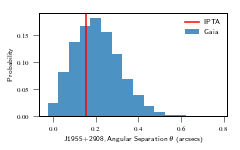

In [37]:
bin_list = auto_bin(.05,0.0,0.8)
weights = hist_weight(seps)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.hist(seps, bin_list, weights=weights, alpha = 0.8, align='left', color = 'C0', label = "Gaia")
plt.axvline(gaia_ipta_sep, color='red', label = "IPTA")
plt.xlabel(r"J1955+2908, Angular Separation $\theta$ (arcsecs)")
plt.ylabel("Probability")
plt.legend(frameon=False)
plt.tight_layout()
#plt.savefig("J1955_Theta_IPTA-GAIA.pdf")

In [38]:
ipta_ras = np.array(ipta_ras) - 298.85

In [39]:
gaia_ras = np.array(gaia_ras) - 298.85

In [40]:
bin_list = auto_bin(np.std(gaia_ras)/4,np.min(gaia_ras)-np.std(gaia_ras)/2,np.max(gaia_ras)+np.std(gaia_ras)/2)
weights = hist_weight(gaia_ras)

/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  import sys


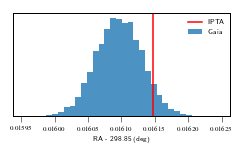

In [42]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.hist(gaia_ras, bin_list, weights=weights, alpha = 0.8, align='left', color = 'C0', label = "Gaia")
plt.axvline(np.median(ipta_ras), color='red', label = "IPTA") #1.3 sigma
plt.xlabel("RA - 298.85 (deg)")
plt.yticks([])
plt.legend(frameon=False)
plt.tight_layout()
plt.savefig("J1955_RA_IPTA-GAIA-25Nov.pdf")

In [43]:
(mu, sigma) = norm.fit(gaia_ras)
diff = (mu-np.median(ipta_ras))/sigma

In [44]:
diff

-1.3469136506191401

In [45]:
gaia_decs = np.array(gaia_decs) - 29.145

In [46]:
ipta_decs = np.array(ipta_decs) - 29.145

In [47]:
max(gaia_decs)

0.0005553909565030324

In [48]:
bin_list = auto_bin(np.std(gaia_decs)/4,np.min(gaia_decs)-np.std(gaia_decs)/2,np.max(gaia_decs)+np.std(gaia_decs)/2)
weights = hist_weight(gaia_decs)

/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  import sys


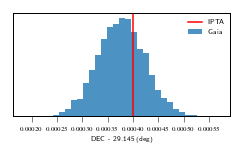

In [49]:
# DEC plot for J1732
plt.hist(gaia_decs, bin_list, weights=weights, alpha = 0.8, align='left', color = 'C0', label = "Gaia")
plt.axvline(np.median(ipta_decs), color='red', label = "IPTA") #0.4 sigma
ax.set_xlim([np.min(ipta_decs),np.max(ipta_decs)])
plt.xlabel("DEC - 29.145 (deg)")
plt.legend(frameon=False)
plt.yticks([])
plt.tight_layout()
#plt.savefig("J1955_DEC_IPTA-GAIA-25Nov.pdf")

In [50]:
(mu, sigma) = norm.fit(gaia_decs)
diff = (mu-np.median(ipta_decs))/sigma


In [51]:
diff

-0.3619188036866633